# Visualizations - Telegram

In [1]:
%pip install trino==0.332.0 trino[sqlalchemy] seaborn polars

  Using cached trino-0.332.0-py3-none-any.whl (57 kB)
  Using cached trino-0.335.0-py3-none-any.whl (57 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached polars-1.31.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.1 MB)
  Using cached lz4-4.4.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached tzlocal-5.3.1-py3-none-any.whl (18 kB)
INFO: pip is looking at multiple versions of trino[sqlalchemy] to determine which version is compatible with other requirements. This could take a while.
  Using cached trino-0.334.0-py3-none-any.whl (57 kB)
  Using cached trino-0.333.0-py3-none-any.whl (57 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import trino.dbapi
import os 
import pandas as pd
import polars as pl
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
TRINO_HOST=os.environ.get("TRINO_HOST")
TRINO_USER=os.environ.get("TRINO_USER")

In [ ]:
with trino.dbapi.connect(host=TRINO_HOST, user=TRINO_USER, catalog='iceberg') as conn:
    cur = conn.cursor()
    schema = cur.execute('describe telegram.messages').fetchall()
    cur.close()
schema

[['date', 'varchar', '', ''],
 ['forwards', 'bigint', '', ''],
 ['pinned', 'boolean', '', ''],
 ['legacy', 'boolean', '', ''],
 ['noforwards', 'boolean', '', ''],
 ['out', 'boolean', '', ''],
 ['peer_id', 'bigint', '', ''],
 ['from_scheduled', 'boolean', '', ''],
 ['post', 'boolean', '', ''],
 ['edit_hide', 'boolean', '', ''],
 ['nr_replies', 'bigint', '', ''],
 ['invert_media', 'boolean', '', ''],
 ['id', 'bigint', '', ''],
 ['mentioned', 'boolean', '', ''],
 ['_timestamp', 'bigint', '', ''],
 ['views', 'bigint', '', ''],
 ['text_urls', 'array(varchar)', '', ''],
 ['peer_type', 'varchar', '', ''],
 ['silent', 'boolean', '', ''],
 ['_table', 'varchar', '', ''],
 ['media_unread', 'boolean', '', ''],
 ['message', 'varchar', '', ''],
 ['has_comments', 'boolean', '', ''],
 ['reactions',
  'row(🔥 bigint, ❤ bigint, 🤬 bigint, 🤡 bigint, 👎 bigint, 👍 bigint, 😱 bigint, 😢 bigint, 😁 bigint, 😐 bigint, 💯 bigint, 🤮 bigint, 👏 bigint, 🤔 bigint, 🙏 bigint, 🤨 bigint, 💔 bigint, \U0001fae1 bigint, ❤\u200d🔥 b

In [86]:
def df_from_db(query, col_names=None, host=TRINO_HOST, user=TRINO_USER, catalog='iceberg', **df_kwargs):
    with trino.dbapi.connect(host=host, user=user, catalog=catalog) as conn:
        df = df_from_db_conn(query, conn, col_names, **df_kwargs)
    return df

def df_from_db_conn(query, conn, col_names=None, **df_kwargs):
    cur = conn.cursor()
    res = cur.execute(query).fetchall()
    cur.close()
    df = pl.DataFrame(res, orient='row', schema=col_names, **df_kwargs)
    return df

# Volume

In [71]:
query = """
with date_count as (
    select id, cast(from_iso8601_timestamp(date) as DATE) as date
    from telegram.messages
)
select date, count(*) from date_count group by date
"""
df = df_from_db(query, ['date', 'message_count'])

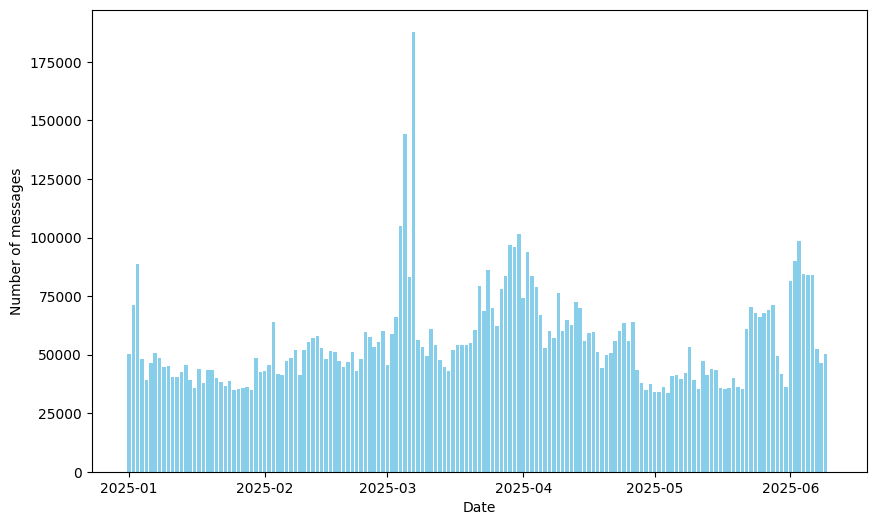

In [72]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x='date', height='message_count', data=df, color='skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Number of messages')
fig.show()

## Content reliability

In [7]:
query = "select * from news.lasser_dq_scores"
domains = df_from_db(query, ['domain', 'reliability'], catalog='db')

In [ ]:
dt_range = pl.datetime_range(
    dt.date(2025, 1, 1),
    dt.date.today() - dt.timedelta(days=2),
    eager=True,
    interval="1d",
)
cols = ["peer_id", "id", "date", "text_urls"]
domain_patt = r"^(?:https?:\/\/)?(?:www\.)?([^:\/\n?]+)"
start_from_idx = 0  # to resume after a crash
daily_stats = []
for dt_from, dt_to in zip(dt_range[start_from_idx:-1], dt_range[start_from_idx + 1 :]):
    query = (
        f"select {', '.join(cols)} from telegram.messages"
        f" where date > '{dt_from}' and date < '{dt_to}' and cardinality(text_urls) > 0"
    )
    df = df_from_db(query, cols)
    if df.is_empty():
        continue
    df = (
        df.explode("text_urls")
        .with_columns(pl.col("text_urls").str.extract(domain_patt).alias("domain"))
        .join(domains, on="domain", how="left")
    )
    day_stats = df.select(
        pl.lit(dt_from.date()).alias("date"),
        pl.col("reliability").mean().alias("mean_rel"),
        url_count=pl.len(),
        prop_tg=(pl.col("domain") == "t.me").sum() / pl.len(),
        prop_labelled=pl.col("reliability").is_not_null().sum() / pl.len(),
    )
    daily_stats.extend(day_stats.to_dicts())

In [95]:
daily_stats = pl.DataFrame(daily_stats, orient='row')

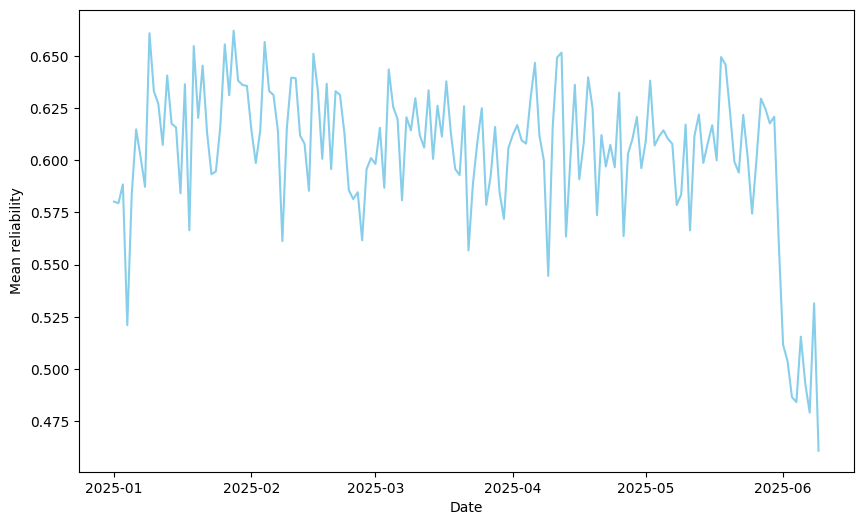

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot('date', 'mean_rel', data=daily_stats, color='skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Mean reliability')
fig.show()

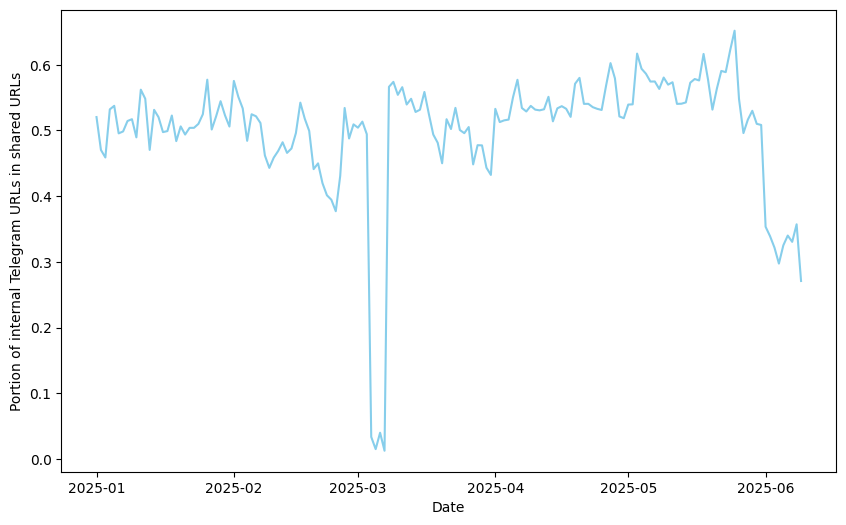

In [102]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot('date', 'prop_tg', data=daily_stats, color='skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Portion of internal Telegram URLs in shared URLs')
fig.show()

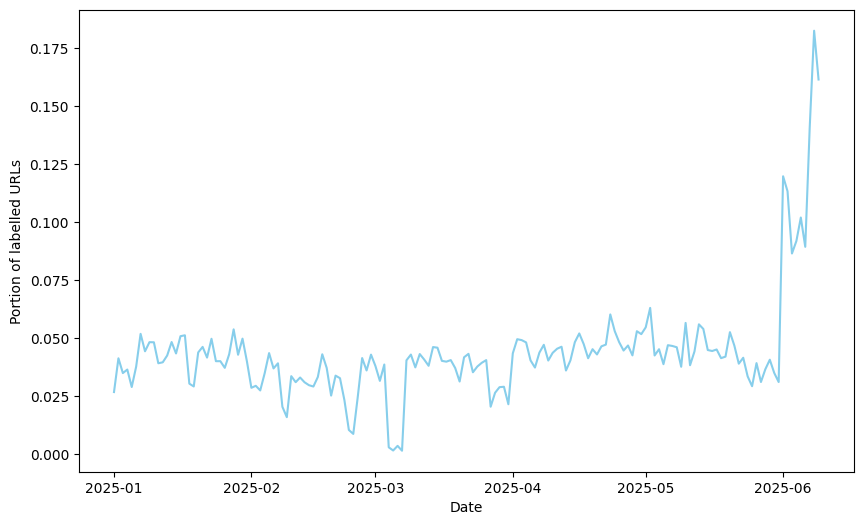

In [101]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot('date', 'prop_labelled', data=daily_stats, color='skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Portion of labelled URLs')
fig.show()

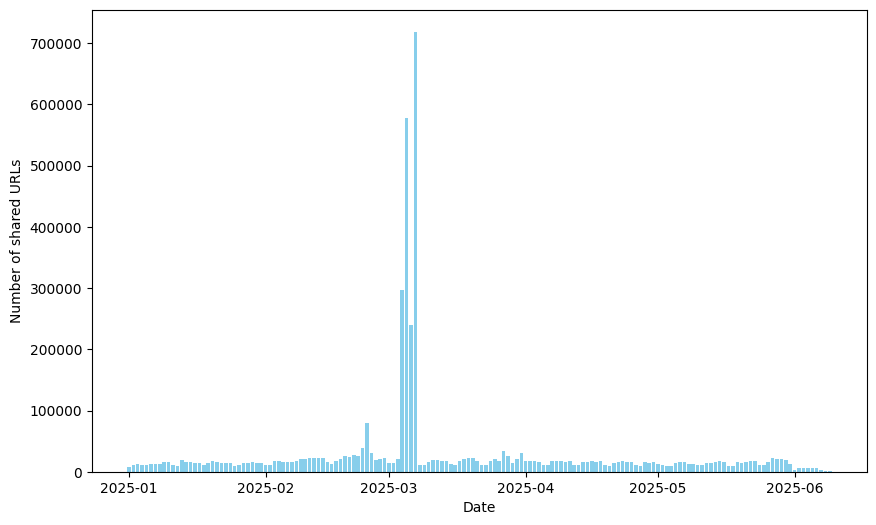

In [98]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x='date', height='url_count', data=daily_stats, color='skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Number of shared URLs')
fig.show()

In [91]:
dt_range[160]

datetime.datetime(2025, 6, 10, 0, 0)

In [90]:
daily_stats[-1]

{'date': datetime.date(2025, 6, 9),
 'mean_rel': 0.4608154959087771,
 'url_count': 1690,
 'prop_tg': 0.2710059171597633,
 'prop_labelled': 0.16153846153846155}

## Check tools output for TG

In [ ]:
with trino.dbapi.connect(host=TRINO_HOST, user=TRINO_USER, catalog='iceberg') as dc_conn:
    cur = dc_conn.cursor()
    a = cur.execute("select * from tools.text_disinformation_signals_detection limit 5").fetchall()

In [ ]:
a[0][3][0]